### Recoded GFP/Cell burden modeling - Varying GFP mRNA concentration - archived simulations

Date: March 2023

Simulations that were not really informative, but are saved here for posterity. 

In [1]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [3]:
# Functions for reading in simulation data

def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.
    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [5]:
# simulation parameters
# RBS strength is aprox. equal to tRNA re-charing rate
time_limit = 500
time_step = 5
transcript_lens = [300, 300]
cellular_transcript_copy_number = 50
transgene_transcript_copy_number = 25
ribosome_copy_number = 500
total_trna = 500
ribosome_binding_rates = [1000, 5000, 10000]
trna_charging_rate = 1000.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = [(0.6, 0.4)]
#codon_comps_1 = (0.9, 0.1)
codon_comps_2 = [(0.6, 0.4), (0.1, 0.9)]

date = "march-13-2023"

In [16]:
!mkdir ../../yaml/march-13-2023
!mkdir ../../output/march-13-2023

for trna_prop in trna_props:
    for comp in codon_comps_2:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../../yaml/{date}")

configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for ribosome_binding_rate in ribosome_binding_rates:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {transgene_transcript_copy_number} " + \
                  f"{ribosome_copy_number} {total_trna} {1000} {ribosome_binding_rate} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [6]:
df_master = None
for ribosome_binding_rate in ribosome_binding_rates:
    df_rib = None
    for codon_comp in codon_comps_2:
        path = f"../output/{date}/two_codon_multi_transcript_0.6_0.4_{codon_comp[0]}_{codon_comp[1]}_0.6_0.4" + \
               f"_{cellular_transcript_copy_number}_{transgene_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
               f"_1000.0_{ribosome_binding_rate}.0_1000.0_1000.0"
        tmp = get_average_protein(path, 0.5, 500, 3)
        tmp["codon_comp"] = codon_comp[0]
        tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
        if df_rib is not None:
            df_rib = df_rib.append(tmp, ignore_index=True)
        else:
            df_rib = tmp
        df_rib["ribosome_binding"] = ribosome_binding_rate

    if df_master is not None:
        df_master = df_master.append(df_rib, ignore_index=True)
    else:
        df_master = df_rib

df_master = df_master[(df_master.time == 500.0)]
df_master = df_master[(df_master.ribosome_binding > 1000)]

In [7]:
pivot = df_master.pivot(index = ["codon_comp", "ribosome_binding"], columns = "species", values = "protein").reset_index()
pivot["GFP"] = pivot["GFP"].fillna(0)

pivot["cellularProtein_transformed"] = pivot["cellularProtein"].groupby([pivot.codon_comp, pivot.ribosome_binding]).transform(lambda x: x/x.max())
pivot["GFP_transformed"] = pivot["GFP"] / (pivot["GFP"] + pivot["cellularProtein"])
pivot["Percent_opt"] = (pivot["codon_comp"] / 0.6 * 100).round().astype("int")
pivot["exp_cellularProtein"] = np.exp(pivot["cellularProtein_transformed"])

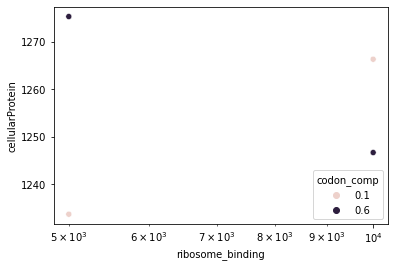

In [8]:
sns.scatterplot(data=pivot, x = "ribosome_binding", y = "cellularProtein", hue = "codon_comp")
plt.xscale("log")

With the simulation parameters chosen, RBS strength doesn't really impact protein expression.